In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import cv2
import os
from segment_anything import build_sam_vit_b
import os
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

BATCH_SIZE = 2
grad_accum_steps = 1

# Enable mixed precision
scaler = torch.cuda.amp.GradScaler()

def create_run_directory():
    """Create a new directory for this training run"""
    base_path = "../../../models/websam"
    os.makedirs(base_path, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(base_path, f"run_{timestamp}")
    os.makedirs(run_dir, exist_ok=True)

    models_dir = os.path.join(run_dir, "models")
    os.makedirs(models_dir, exist_ok=True)
    return run_dir, models_dir

def plot_metrics(metrics, run_dir, epoch):
    """Plot training and validation metrics"""
    metric_keys = ['loss', 'pixel_accuracy', 'f1', 'pb3', 'rb3', 'fb3']
    os.makedirs(os.path.join(run_dir, 'plots'), exist_ok=True)
    epochs = list(range(1, epoch + 1))
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(metric_keys):
        if metric in metrics['train'] and metric in metrics['val']:
            axes[i].plot(epochs, metrics['train'][metric], 'b-', label=f'Training')
            axes[i].plot(epochs, metrics['val'][metric], 'r-', label=f'Validation')
            axes[i].set_title(f'{metric.capitalize()}')
            axes[i].set_xlabel('Epochs')
            axes[i].set_ylabel(metric)
            axes[i].legend()
            axes[i].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, 'plots', f'metrics_epoch_{epoch}.png'))
    plt.close()

def visualize_predictions(images, targets, predictions, epoch, run_dir, num_samples=3):
    """Visualize a few sample predictions"""
    os.makedirs(os.path.join(run_dir, 'visualizations'), exist_ok=True)
    
    for i in range(min(num_samples, len(images))):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        img = images[i].cpu().permute(1, 2, 0).numpy()
        if img.max() > 1.0:
            img = img / 255.0
        axes[0].imshow(img)
        axes[0].set_title("Input Image")
        axes[0].axis('off')
        
        # Ground truth - ensure it's a proper 2D tensor for visualization
        target = targets[i]
        # If we have a multi-segment mask (3D tensor), we need to reduce it to 2D
        if len(target.shape) == 3:
            target = target[0]
        
        # Further ensure it's a 2D tensor (no extra dimensions)
        if len(target.shape) > 2:
            target = target.squeeze()
            
        axes[1].imshow(target.cpu().numpy(), cmap='gray')
        axes[1].set_title("Ground Truth")
        axes[1].axis('off')
        
        pred = predictions[i]
        # Handle the case where prediction is also multi-segment
        if len(pred.shape) == 3:
            # Take the first prediction or combine all predictions
            pred = pred[0]
            
        # Further ensure it's a 2D tensor (no extra dimensions)
        if len(pred.shape) > 2:
            pred = pred.squeeze()
            
        pred_display = (torch.sigmoid(pred) > 0.5).float().cpu().numpy()
        axes[2].imshow(pred_display, cmap='gray')
        axes[2].set_title("Prediction")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(run_dir, 'visualizations', f'epoch_{epoch+1}_sample_{i}.png'))
        plt.close()

def plot_training_progress(train_metrics_history, val_metrics_history, run_dir):
    """Plot training and validation metrics over epochs"""
    num_epochs = len(train_metrics_history['loss'])
    epochs = range(1, num_epochs + 1)
    
    metrics = ['loss', 'pixel_accuracy', 'f1', 'pb3', 'rb3', 'fb3']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        axes[i].plot(epochs, train_metrics_history[metric], 'b-', label=f'Training {metric}')
        axes[i].plot(epochs, val_metrics_history[metric], 'r-', label=f'Validation {metric}')
        axes[i].set_title(f'{metric.capitalize()}')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel(metric)
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, 'training_progress.png'))
    plt.close()


# Define the combined BCE and IoU Loss
class BCEIoULoss(nn.Module):
    def __init__(self):
        super(BCEIoULoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)

        # IoU loss
        inputs_sigmoid = torch.sigmoid(inputs)
        #print(f"inputs_sigmoid shape: {inputs_sigmoid.shape}, targets shape: {targets.shape}")
        intersection = (inputs_sigmoid * targets).sum((1, 2))
        total = (inputs_sigmoid + targets).sum((1, 2))
        union = total - intersection
        iou = (intersection + 1e-6) / (union + 1e-6)
        iou_loss = 1 - iou.mean()
        total_loss = bce_loss + iou_loss.mean()
        #print(f"BCE: {bce_loss.item()}, IoU: {iou_loss.item()}, Total: {total_loss.item()}")

        return total_loss

class WebSegDataset(Dataset):
    def __init__(self, root_dir, image_size=1024):  # Reduced size for efficiency
        self.image_dir = os.path.join(root_dir, "images")
        self.box_dir = os.path.join(root_dir, "boxes")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.image_size = image_size
        self.image_filenames = sorted(os.listdir(self.image_dir))  

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        box_path = os.path.join(self.box_dir, self.image_filenames[idx].replace(".png", ".npy"))
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace(".png", ".npy"))

        # Load image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (self.image_size, self.image_size))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0  # Normalize
        
        # Load bounding box
        boxes = np.load(box_path)
        
        # Load mask
        mask = np.load(mask_path)

        # Convert to tensors efficiently
        image = torch.tensor(image).permute(2, 0, 1).contiguous()  # Contiguous for speed
        boxes = torch.tensor(boxes, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, boxes, mask
    
def collate_fn(batch):
    images, boxes, masks = zip(*batch)
    images = torch.stack(images)
    return images, boxes, masks

def calculate_metrics(pred_masks, target_masks):
    """Calculate PB3, RB3, F*B3, F1, and Pixel Accuracy"""
    #print("calculate_metrics")
    # Convert logits to binary predictions
    pred_masks = (torch.sigmoid(pred_masks) > 0.5)  # Returns boolean tensor
    target_masks = (target_masks > 0.5)  # Convert target to boolean tensor

    #print(pred_masks.shape, target_masks.shape)
    
    # Pixel Accuracy
    pixel_accuracy = (pred_masks == target_masks).float().mean()
    
    #print(pixel_accuracy)

    # Convert to float for calculations
    pred_float = pred_masks.float()
    target_float = target_masks.float()
    
    # F1 Score
    intersection = (pred_float * target_float).sum()
    precision = intersection / (pred_float.sum() + 1e-6)
    recall = intersection / (target_float.sum() + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    # B3 metrics
    pb3 = precision  # For pixels, PB3 is equivalent to precision
    rb3 = recall    # For pixels, RB3 is equivalent to recall
    fb3 = f1        # For pixels, F*B3 is equivalent to F1
    
    return {
        'pixel_accuracy': pixel_accuracy.item(),
        'f1': f1.item(),
        'pb3': pb3.item(),
        'rb3': rb3.item(),
        'fb3': fb3.item()
    }
class MetricTracker:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.metrics = {
            'loss': [],
            'pixel_accuracy': [],
            'f1': [],
            'pb3': [],
            'rb3': [],
            'fb3': []
        }
    
    def update(self, metrics_dict):
        for key, value in metrics_dict.items():
            self.metrics[key].append(value)
    
    def get_averages(self):
        return {key: np.mean(values) for key, values in self.metrics.items()}

def resume_training(run_dir, model, optimizer, scheduler):
    """Load checkpoint and metrics to resume training"""
    models_dir = os.path.join(run_dir, "models")
    metrics_file = os.path.join(run_dir, 'metrics.csv')

    # Find the last completed epoch from metrics.csv
    last_completed_epoch = 0
    if os.path.exists(metrics_file):
        df = pd.read_csv(metrics_file)
        if not df.empty:
            last_completed_epoch = df['epoch'].max()
            print(f"Last completed epoch from metrics: {last_completed_epoch}")


    #    # Find the checkpoint to load
    checkpoint_path = None
    checkpoints = [f for f in os.listdir(models_dir) if f.startswith('checkpoint_epoch_')]
    
    if checkpoints:
        # Find the most recent checkpoint
        checkpoint_epoch = max([int(f.split('_')[-1].split('.')[0]) for f in checkpoints])
        checkpoint_path = os.path.join(models_dir, f'checkpoint_epoch_{checkpoint_epoch}.pth')
    
    if not checkpoint_path and os.path.exists(os.path.join(models_dir, 'best_model.pth')):
        checkpoint_path = os.path.join(models_dir, 'best_model.pth')
    
    if not checkpoint_path:
        raise FileNotFoundError("No checkpoints found to resume from")
    
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    
    # Load model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Get the last completed epoch and best loss
    checkpoint_epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    start_epoch = max(checkpoint_epoch, last_completed_epoch) + 1
    print(f"Resuming from epoch {start_epoch} (checkpoint was from epoch {checkpoint_epoch})")
    
    epoch_metrics = load_metrics_up_to_epoch(metrics_file, start_epoch - 1)
    
    # Create scheduler with correct position
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, last_epoch=start_epoch-1)
    
    # Clean up visualization and plot files for epochs that will be overwritten
    cleanup_files_for_resuming(run_dir, start_epoch)
    
    return start_epoch, best_loss, epoch_metrics, scheduler

def validate(model, val_loader, criterion, device, epoch=0, run_dir=None, visualize=False):
    model.eval()
    val_tracker = MetricTracker()
    
    # For visualization
    visualization_done = False
    
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc=f"Validating") as pbar:
            for step, (images, boxes, masks) in enumerate(val_loader):
                images = images.cuda()
                boxes = [b.cuda() for b in boxes]
                masks = [m.cuda() for m in masks]
                
                batched_input = [
                    {
                        "image": image,
                        "boxes": box,
                        "original_size": (1024, 1024)
                    } for image, box in zip(images, boxes)
                ]
                
                outputs = model(batched_input, multimask_output=False)
                
                # Visualize the first batch if enabled
                if visualize and run_dir is not None and not visualization_done:
                    sample_images = images[:min(3, len(images))]
                    sample_targets = []
                    sample_preds = []
                    
                    for i in range(min(3, len(outputs))):
                        # Get first prediction (same as in training)
                        pred_mask = outputs[i]["low_res_logits"][0]  # Shape [1, 256, 256]
                        
                        # Create combined ground truth mask (same as in training)
                        target_mask = masks[i]
                        combined_gt = torch.any(target_mask > 0.5, dim=0).float()
                        
                        # Resize the combined target to match pred size
                        h, w = pred_mask.shape[-2:]
                        target_mask_resized = F.interpolate(
                            combined_gt.unsqueeze(0).unsqueeze(0),
                            size=(h, w),
                            mode='bilinear'
                        ).squeeze(0)  # Shape [1, h, w]
                        
                        sample_targets.append(target_mask_resized.squeeze(0))  # Convert to [h, w] for visualization
                        sample_preds.append(pred_mask.squeeze(0))  # Convert to [h, w] for visualization
                    
                    visualize_predictions(sample_images, sample_targets, sample_preds, epoch, run_dir)
                    visualization_done = True
                
                # Calculate metrics
                batch_metrics = []
                for output, target_mask in zip(outputs, masks):
                    # Create combined ground truth mask
                    combined_gt = torch.any(target_mask > 0.5, dim=0).float()
                    
                    # Resize to match prediction resolution
                    combined_gt = F.interpolate(
                        combined_gt.unsqueeze(0).unsqueeze(0),
                        size=(256, 256),
                        mode='bilinear'
                    ).squeeze(0)  # Keep channel dim
                    
                    # Take first prediction
                    pred_mask = output["low_res_logits"][0]  # Shape [1, 256, 256]
                    
                    loss = criterion(pred_mask, combined_gt)
                    metrics = calculate_metrics(pred_mask, combined_gt)
                    metrics['loss'] = loss.item()
                    batch_metrics.append(metrics)
                
                # Average batch metrics
                avg_batch_metrics = {k: np.mean([m[k] for m in batch_metrics]) for k in batch_metrics[0].keys()}
                val_tracker.update(avg_batch_metrics)
                
                # Update progress bar with metrics
                metrics_str = ", ".join([f"{k}: {avg_batch_metrics[k]:.4f}" for k in sorted(avg_batch_metrics.keys())])
                pbar.set_postfix_str(metrics_str)
                
                pbar.update(1)
                
                #if step == 20:
                    #break
    
    return val_tracker.get_averages()

def save_checkpoint(model, optimizer, epoch, best_loss, metrics, run_dir, is_best=False):
    """Save model checkpoint"""
    models_dir = os.path.join(run_dir, "models")
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss,
        'metrics': metrics
    }
    
    if is_best:
        filename = os.path.join(models_dir, 'best_model.pth')
    else:
        filename = os.path.join(models_dir, f'checkpoint_epoch_{epoch+1}.pth')
    
    torch.save(checkpoint, filename)

def update_metrics_csv(metrics_dict, epoch, run_dir, mode='train'):
    """Update the metrics CSV file with new epoch results"""
    metrics_file = os.path.join(run_dir, 'metrics.csv')
    
    # Prepare the metrics row
    row_dict = {
        'epoch': epoch + 1,
        'mode': mode
    }
    row_dict.update({f"{mode}_{k}": v for k, v in metrics_dict.items()})
    
    # If file exists, append to it
    if os.path.exists(metrics_file):
        df = pd.read_csv(metrics_file)
        df = pd.concat([df, pd.DataFrame([row_dict])], ignore_index=True)
    else:
        df = pd.DataFrame([row_dict])
    
    # Save to CSV
    df.to_csv(metrics_file, index=False)

# Modified training loop
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    # Create run directory
    run_dir, models_dir = create_run_directory()
    print(f"Saving results to: {run_dir}")
    
    best_loss = float('inf')

    epoch_metrics = {
        'train': {'loss': [], 'pixel_accuracy': [], 'f1': [], 'pb3': [], 'rb3': [], 'fb3': []},
        'val': {'loss': [], 'pixel_accuracy': [], 'f1': [], 'pb3': [], 'rb3': [], 'fb3': []}
    }
    
    for epoch in range(num_epochs):
        model.train()
        train_tracker = MetricTracker()
        i = 0
        with tqdm(total=len(train_loader) * BATCH_SIZE, desc=f"Epoch {epoch+1}/{num_epochs} - Training") as pbar:

            """for images, boxes, masks in train_loader:
                print("Image shape:", images.shape)
                print("Box sample:", boxes[0].shape, boxes[0])
                print("Mask shape:", masks[0].shape)
                print("Mask min/max:", masks[0].min(), masks[0].max())
                break"""

            for step, (images, boxes, masks) in enumerate(train_loader):
                images = images.cuda()
                boxes = [b.cuda() for b in boxes]
                masks = [m.cuda() for m in masks]
                
                with torch.cuda.amp.autocast():
                    batched_input = [
                        {
                            "image": image,
                            "boxes": box,
                            "original_size": (1024, 1024)
                        } for image, box in zip(images, boxes)
                    ]
                    outputs = model(batched_input, multimask_output=False)
                    
                    batch_metrics = []
                    losses = []
                    for output, target_mask in zip(outputs, masks):
                        # Create combined ground truth mask
                        combined_gt = torch.any(target_mask > 0.5, dim=0).float()
                        
                        # Resize to match prediction resolution (256x256)
                        combined_gt = F.interpolate(combined_gt.unsqueeze(0).unsqueeze(0), 
                                                    size=(256, 256), 
                                                    mode='bilinear').squeeze(0)  # Keep channel dim, so shape is [1, 256, 256]
                        
                        # Take first prediction and keep channel dimension
                        pred_mask = output["low_res_logits"][0]  # Shape should be [1, 256, 256]
                        #print(f"pred_mask shape: {pred_mask.shape}, combined_gt shape: {combined_gt.shape}")
                        loss = criterion(pred_mask, combined_gt)
                        losses.append(loss)
                        
                        metrics = calculate_metrics(pred_mask, combined_gt)
                        metrics['loss'] = loss.item()
                        batch_metrics.append(metrics)
                    
                    loss = torch.stack(losses).mean() / grad_accum_steps

                scaler.scale(loss).backward()

                """for name, param in sam.named_parameters():
                    if param.requires_grad:
                        print(f"{name}: grad_norm = {param.grad.norm().item() if param.grad is not None else 'None'}")"""
                
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                if ((step + 1) % grad_accum_steps == 0) or (step + 1 == len(train_loader)):
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                # metrics and logging
                avg_batch_metrics = {k: np.mean([m[k] for m in batch_metrics]) for k in batch_metrics[0].keys()}
                train_tracker.update(avg_batch_metrics)
                metrics_str = ", ".join([f"{k}: {avg_batch_metrics[k]:.4f}" for k in sorted(avg_batch_metrics.keys())])
                pbar.set_postfix_str(metrics_str)
                pbar.update(BATCH_SIZE)

                del images, boxes, masks, outputs, pred_mask, target_mask, loss
                torch.cuda.empty_cache()
                gc.collect()

                i += 1
                #if i == 20:
                #    break
        

        train_metrics = train_tracker.get_averages()
        for k, v in train_metrics.items():
            if k in epoch_metrics['train']:
                epoch_metrics['train'][k].append(v)
        
        scheduler.step()
        
        # Validation phase
        val_metrics = validate(model, val_loader, criterion, device, epoch=epoch, 
                       run_dir=run_dir, visualize=(epoch % 1 == 0))
        for k, v in val_metrics.items():
            if k in epoch_metrics['val']:
                epoch_metrics['val'][k].append(v)

        update_metrics_csv(train_metrics, epoch, run_dir, mode='train')
        update_metrics_csv(val_metrics, epoch, run_dir, mode='val')

        # Save checkpoint if best model
        if val_metrics['loss'] < best_loss:
            best_loss = val_metrics['loss']
            save_checkpoint(model, optimizer, epoch, best_loss, val_metrics, run_dir, is_best=True)
        
        # Save regular checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            save_checkpoint(model, optimizer, epoch, best_loss, val_metrics, run_dir, is_best=False)
        
        plot_metrics(epoch_metrics, run_dir, epoch+1)
        plot_training_progress(epoch_metrics['train'], epoch_metrics['val'], run_dir)

        # Print epoch summary
        print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
        print("Training metrics:", {k: f"{v:.4f}" for k, v in train_metrics.items()})
        print("Validation metrics:", {k: f"{v:.4f}" for k, v in val_metrics.items()})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
# Initialize model
sam = build_sam_vit_b(
    checkpoint="../../../models/websam/sam_vit_b_01ec64.pth",
    strict_weights= False,
    freeze_encoder=True
)

if torch.cuda.is_available():
    print("cuda")
    sam = sam.cuda()
train_dataset = WebSegDataset(root_dir="/media/bruno/New Volume/vt2-visual-webseg/data/webis-webseg-20-sam-big-segments-full/train/")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataset = WebSegDataset(root_dir="/media/bruno/New Volume/vt2-visual-webseg/data/webis-webseg-20-sam-big-segments-full/val/")
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

num_epochs = 20
optimizer = optim.AdamW(sam.parameters(), lr=2e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = BCEIoULoss()
train(sam, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device)

/tmp/ipykernel_85201/2411487075.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Device: cuda
../../../models/websam/sam_vit_b_01ec64.pth
cuda


/media/bruno/New Volume/vt2-visual-webseg/src/websam/segment-anything/segment_anything/build_sam.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sam.load_state_dict(to

Saving results to: ../../../models/websam/run_20250225_163753


Epoch 1/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 849/849 [04:51<00:00,  2.91it/s, f1: 0.8438, fb3: 0.8438, loss: 0.5298, pb3: 0.8419, pixel_accuracy: 0.8842, rb3: 0.8648]



Epoch [1/20] Summary:
Training metrics: {'loss': '0.6755', 'pixel_accuracy': '0.8460', 'f1': '0.8580', 'pb3': '0.8385', 'rb3': '0.9060', 'fb3': '0.8580'}
Validation metrics: {'loss': '0.5638', 'pixel_accuracy': '0.8688', 'f1': '0.8786', 'pb3': '0.8510', 'rb3': '0.9277', 'fb3': '0.8786'}


Epoch 2/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 849/849 [04:51<00:00,  2.91it/s, f1: 0.8074, fb3: 0.8074, loss: 0.8511, pb3: 0.8096, pixel_accuracy: 0.8462, rb3: 0.8505]



Epoch [2/20] Summary:
Training metrics: {'loss': '0.5577', 'pixel_accuracy': '0.8708', 'f1': '0.8797', 'pb3': '0.8615', 'rb3': '0.9192', 'fb3': '0.8797'}
Validation metrics: {'loss': '0.5760', 'pixel_accuracy': '0.8636', 'f1': '0.8745', 'pb3': '0.8382', 'rb3': '0.9345', 'fb3': '0.8745'}


Epoch 3/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 849/849 [04:50<00:00,  2.92it/s, f1: 0.7592, fb3: 0.7592, loss: 0.7688, pb3: 0.7379, pixel_accuracy: 0.8059, rb3: 0.8656]



Epoch [3/20] Summary:
Training metrics: {'loss': '0.5341', 'pixel_accuracy': '0.8769', 'f1': '0.8849', 'pb3': '0.8690', 'rb3': '0.9202', 'fb3': '0.8849'}
Validation metrics: {'loss': '0.5386', 'pixel_accuracy': '0.8724', 'f1': '0.8826', 'pb3': '0.8453', 'rb3': '0.9431', 'fb3': '0.8826'}


Epoch 4/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 849/849 [04:52<00:00,  2.91it/s, f1: 0.8162, fb3: 0.8162, loss: 0.7689, pb3: 0.8274, pixel_accuracy: 0.8545, rb3: 0.8384]



Epoch [4/20] Summary:
Training metrics: {'loss': '0.5176', 'pixel_accuracy': '0.8810', 'f1': '0.8885', 'pb3': '0.8726', 'rb3': '0.9229', 'fb3': '0.8885'}
Validation metrics: {'loss': '0.5214', 'pixel_accuracy': '0.8766', 'f1': '0.8869', 'pb3': '0.8487', 'rb3': '0.9472', 'fb3': '0.8869'}


Epoch 5/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 849/849 [04:47<00:00,  2.95it/s, f1: 0.8546, fb3: 0.8546, loss: 0.7894, pb3: 0.8978, pixel_accuracy: 0.8770, rb3: 0.8302]



Epoch [5/20] Summary:
Training metrics: {'loss': '0.5017', 'pixel_accuracy': '0.8849', 'f1': '0.8920', 'pb3': '0.8764', 'rb3': '0.9248', 'fb3': '0.8920'}
Validation metrics: {'loss': '0.5094', 'pixel_accuracy': '0.8830', 'f1': '0.8891', 'pb3': '0.8758', 'rb3': '0.9202', 'fb3': '0.8891'}


Epoch 6/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 849/849 [04:50<00:00,  2.92it/s, f1: 0.8343, fb3: 0.8343, loss: 0.7334, pb3: 0.8532, pixel_accuracy: 0.8648, rb3: 0.8450]



Epoch [6/20] Summary:
Training metrics: {'loss': '0.4888', 'pixel_accuracy': '0.8876', 'f1': '0.8947', 'pb3': '0.8796', 'rb3': '0.9265', 'fb3': '0.8947'}
Validation metrics: {'loss': '0.5385', 'pixel_accuracy': '0.8765', 'f1': '0.8872', 'pb3': '0.8497', 'rb3': '0.9474', 'fb3': '0.8872'}


Epoch 7/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 849/849 [04:50<00:00,  2.92it/s, f1: 0.8457, fb3: 0.8457, loss: 0.8828, pb3: 0.9024, pixel_accuracy: 0.8714, rb3: 0.8097]



Epoch [7/20] Summary:
Training metrics: {'loss': '0.4771', 'pixel_accuracy': '0.8910', 'f1': '0.8974', 'pb3': '0.8830', 'rb3': '0.9275', 'fb3': '0.8974'}
Validation metrics: {'loss': '0.5011', 'pixel_accuracy': '0.8868', 'f1': '0.8917', 'pb3': '0.8903', 'rb3': '0.9095', 'fb3': '0.8917'}


Epoch 8/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 849/849 [04:52<00:00,  2.90it/s, f1: 0.8648, fb3: 0.8648, loss: 0.8913, pb3: 0.9139, pixel_accuracy: 0.8824, rb3: 0.8342]



Epoch [8/20] Summary:
Training metrics: {'loss': '0.4668', 'pixel_accuracy': '0.8935', 'f1': '0.9001', 'pb3': '0.8848', 'rb3': '0.9306', 'fb3': '0.9001'}
Validation metrics: {'loss': '0.4964', 'pixel_accuracy': '0.8866', 'f1': '0.8945', 'pb3': '0.8688', 'rb3': '0.9394', 'fb3': '0.8945'}


Epoch 9/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 849/849 [05:04<00:00,  2.79it/s, f1: 0.8579, fb3: 0.8579, loss: 0.9404, pb3: 0.9543, pixel_accuracy: 0.8809, rb3: 0.7822]



Epoch [9/20] Summary:
Training metrics: {'loss': '0.4542', 'pixel_accuracy': '0.8965', 'f1': '0.9026', 'pb3': '0.8878', 'rb3': '0.9319', 'fb3': '0.9026'}
Validation metrics: {'loss': '0.5183', 'pixel_accuracy': '0.8849', 'f1': '0.8891', 'pb3': '0.9041', 'rb3': '0.8901', 'fb3': '0.8891'}


Epoch 10/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 849/849 [05:04<00:00,  2.78it/s, f1: 0.8581, fb3: 0.8581, loss: 0.9457, pb3: 0.9445, pixel_accuracy: 0.8785, rb3: 0.7918]



Epoch [10/20] Summary:
Training metrics: {'loss': '0.4462', 'pixel_accuracy': '0.8989', 'f1': '0.9047', 'pb3': '0.8907', 'rb3': '0.9329', 'fb3': '0.9047'}
Validation metrics: {'loss': '0.5113', 'pixel_accuracy': '0.8881', 'f1': '0.8915', 'pb3': '0.9031', 'rb3': '0.8958', 'fb3': '0.8915'}


Epoch 11/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 849/849 [04:59<00:00,  2.84it/s, f1: 0.8618, fb3: 0.8618, loss: 0.8725, pb3: 0.9124, pixel_accuracy: 0.8826, rb3: 0.8281]



Epoch [11/20] Summary:
Training metrics: {'loss': '0.4342', 'pixel_accuracy': '0.9022', 'f1': '0.9076', 'pb3': '0.8938', 'rb3': '0.9345', 'fb3': '0.9076'}
Validation metrics: {'loss': '0.4935', 'pixel_accuracy': '0.8867', 'f1': '0.8953', 'pb3': '0.8641', 'rb3': '0.9465', 'fb3': '0.8953'}


Epoch 12/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 849/849 [04:55<00:00,  2.87it/s, f1: 0.8776, fb3: 0.8776, loss: 0.7771, pb3: 0.9437, pixel_accuracy: 0.8914, rb3: 0.8264]



Epoch [12/20] Summary:
Training metrics: {'loss': '0.4228', 'pixel_accuracy': '0.9046', 'f1': '0.9099', 'pb3': '0.8956', 'rb3': '0.9368', 'fb3': '0.9099'}
Validation metrics: {'loss': '0.4812', 'pixel_accuracy': '0.8919', 'f1': '0.8979', 'pb3': '0.8810', 'rb3': '0.9307', 'fb3': '0.8979'}


Epoch 13/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 849/849 [04:55<00:00,  2.87it/s, f1: 0.8797, fb3: 0.8797, loss: 0.8766, pb3: 0.9644, pixel_accuracy: 0.8923, rb3: 0.8125]



Epoch [13/20] Summary:
Training metrics: {'loss': '0.4086', 'pixel_accuracy': '0.9085', 'f1': '0.9131', 'pb3': '0.8995', 'rb3': '0.9380', 'fb3': '0.9131'}
Validation metrics: {'loss': '0.4894', 'pixel_accuracy': '0.8927', 'f1': '0.8992', 'pb3': '0.8796', 'rb3': '0.9353', 'fb3': '0.8992'}


Epoch 14/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 849/849 [04:54<00:00,  2.88it/s, f1: 0.8770, fb3: 0.8770, loss: 0.7959, pb3: 0.9469, pixel_accuracy: 0.8911, rb3: 0.8224]



Epoch [14/20] Summary:
Training metrics: {'loss': '0.3966', 'pixel_accuracy': '0.9116', 'f1': '0.9161', 'pb3': '0.9023', 'rb3': '0.9406', 'fb3': '0.9161'}
Validation metrics: {'loss': '0.4929', 'pixel_accuracy': '0.8908', 'f1': '0.8978', 'pb3': '0.8773', 'rb3': '0.9352', 'fb3': '0.8978'}


Epoch 15/20 - Training:   0%|          | 0/6792 [00:00<?, ?it/s]/tmp/ipykernel_85201/2411487075.py:408: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/20 - Training:   1%|▏         | 94/6792 [00:32<39:09,  2.85it/s, f1: 0.8649, fb3: 0.8649, loss: 0.6829, pb3: 0.8148, pixel_accuracy: 0.8331, rb3: 0.9220]


OutOfMemoryError: CUDA out of memory. Tried to allocate 428.00 MiB. GPU 0 has a total capacity of 23.56 GiB of which 199.12 MiB is free. Including non-PyTorch memory, this process has 22.59 GiB memory in use. Of the allocated memory 21.59 GiB is allocated by PyTorch, and 684.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import cv2
import os
from segment_anything import build_sam_vit_b
import os
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

BATCH_SIZE = 2
grad_accum_steps = 1

# Enable mixed precision
scaler = torch.cuda.amp.GradScaler()

def create_run_directory():
    """Create a new directory for this training run"""
    base_path = "../../../models/websam"
    os.makedirs(base_path, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(base_path, f"run_{timestamp}")
    os.makedirs(run_dir, exist_ok=True)

    models_dir = os.path.join(run_dir, "models")
    os.makedirs(models_dir, exist_ok=True)
    return run_dir, models_dir

def plot_metrics(metrics, run_dir, epoch):
    """Plot training and validation metrics"""
    metric_keys = ['loss', 'pixel_accuracy', 'f1', 'pb3', 'rb3', 'fb3']
    os.makedirs(os.path.join(run_dir, 'plots'), exist_ok=True)
    epochs = list(range(1, epoch + 1))
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(metric_keys):
        if metric in metrics['train'] and metric in metrics['val']:
            axes[i].plot(epochs, metrics['train'][metric], 'b-', label=f'Training')
            axes[i].plot(epochs, metrics['val'][metric], 'r-', label=f'Validation')
            axes[i].set_title(f'{metric.capitalize()}')
            axes[i].set_xlabel('Epochs')
            axes[i].set_ylabel(metric)
            axes[i].legend()
            axes[i].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, 'plots', f'metrics_epoch_{epoch}.png'))
    plt.close()

def visualize_predictions(images, targets, predictions, epoch, run_dir, num_samples=3):
    """Visualize a few sample predictions"""
    os.makedirs(os.path.join(run_dir, 'visualizations'), exist_ok=True)
    
    for i in range(min(num_samples, len(images))):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        img = images[i].cpu().permute(1, 2, 0).numpy()
        if img.max() > 1.0:
            img = img / 255.0
        axes[0].imshow(img)
        axes[0].set_title("Input Image")
        axes[0].axis('off')
        
        # Ground truth - ensure it's a proper 2D tensor for visualization
        target = targets[i]
        # If we have a multi-segment mask (3D tensor), we need to reduce it to 2D
        if len(target.shape) == 3:
            target = target[0]
        
        # Further ensure it's a 2D tensor (no extra dimensions)
        if len(target.shape) > 2:
            target = target.squeeze()
            
        axes[1].imshow(target.cpu().numpy(), cmap='gray')
        axes[1].set_title("Ground Truth")
        axes[1].axis('off')
        
        pred = predictions[i]
        # Handle the case where prediction is also multi-segment
        if len(pred.shape) == 3:
            # Take the first prediction or combine all predictions
            pred = pred[0]
            
        # Further ensure it's a 2D tensor (no extra dimensions)
        if len(pred.shape) > 2:
            pred = pred.squeeze()
            
        pred_display = (torch.sigmoid(pred) > 0.5).float().cpu().numpy()
        axes[2].imshow(pred_display, cmap='gray')
        axes[2].set_title("Prediction")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(run_dir, 'visualizations', f'epoch_{epoch+1}_sample_{i}.png'))
        plt.close()

def plot_training_progress(train_metrics_history, val_metrics_history, run_dir):
    """Plot training and validation metrics over epochs"""
    num_epochs = len(train_metrics_history['loss'])
    epochs = range(1, num_epochs + 1)
    
    metrics = ['loss', 'pixel_accuracy', 'f1', 'pb3', 'rb3', 'fb3']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        axes[i].plot(epochs, train_metrics_history[metric], 'b-', label=f'Training {metric}')
        axes[i].plot(epochs, val_metrics_history[metric], 'r-', label=f'Validation {metric}')
        axes[i].set_title(f'{metric.capitalize()}')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel(metric)
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, 'training_progress.png'))
    plt.close()


# Define the combined BCE and IoU Loss
class BCEIoULoss(nn.Module):
    def __init__(self):
        super(BCEIoULoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)

        # IoU loss
        inputs_sigmoid = torch.sigmoid(inputs)
        #print(f"inputs_sigmoid shape: {inputs_sigmoid.shape}, targets shape: {targets.shape}")
        intersection = (inputs_sigmoid * targets).sum((1, 2))
        total = (inputs_sigmoid + targets).sum((1, 2))
        union = total - intersection
        iou = (intersection + 1e-6) / (union + 1e-6)
        iou_loss = 1 - iou.mean()
        total_loss = bce_loss + iou_loss.mean()
        #print(f"BCE: {bce_loss.item()}, IoU: {iou_loss.item()}, Total: {total_loss.item()}")

        return total_loss

class WebSegDataset(Dataset):
    def __init__(self, root_dir, image_size=1024):  # Reduced size for efficiency
        self.image_dir = os.path.join(root_dir, "images")
        self.box_dir = os.path.join(root_dir, "boxes")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.image_size = image_size
        self.image_filenames = sorted(os.listdir(self.image_dir))  

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        box_path = os.path.join(self.box_dir, self.image_filenames[idx].replace(".png", ".npy"))
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace(".png", ".npy"))

        # Load image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (self.image_size, self.image_size))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0  # Normalize
        
        # Load bounding box
        boxes = np.load(box_path)
        
        # Load mask
        mask = np.load(mask_path)

        # Convert to tensors efficiently
        image = torch.tensor(image).permute(2, 0, 1).contiguous()  # Contiguous for speed
        boxes = torch.tensor(boxes, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, boxes, mask
    
def collate_fn(batch):
    images, boxes, masks = zip(*batch)
    images = torch.stack(images)
    return images, boxes, masks

def calculate_metrics(pred_masks, target_masks):
    """Calculate PB3, RB3, F*B3, F1, and Pixel Accuracy"""
    #print("calculate_metrics")
    # Convert logits to binary predictions
    pred_masks = (torch.sigmoid(pred_masks) > 0.5)  # Returns boolean tensor
    target_masks = (target_masks > 0.5)  # Convert target to boolean tensor

    #print(pred_masks.shape, target_masks.shape)
    
    # Pixel Accuracy
    pixel_accuracy = (pred_masks == target_masks).float().mean()
    
    #print(pixel_accuracy)

    # Convert to float for calculations
    pred_float = pred_masks.float()
    target_float = target_masks.float()
    
    # F1 Score
    intersection = (pred_float * target_float).sum()
    precision = intersection / (pred_float.sum() + 1e-6)
    recall = intersection / (target_float.sum() + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    # B3 metrics
    pb3 = precision  # For pixels, PB3 is equivalent to precision
    rb3 = recall    # For pixels, RB3 is equivalent to recall
    fb3 = f1        # For pixels, F*B3 is equivalent to F1
    
    return {
        'pixel_accuracy': pixel_accuracy.item(),
        'f1': f1.item(),
        'pb3': pb3.item(),
        'rb3': rb3.item(),
        'fb3': fb3.item()
    }
class MetricTracker:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.metrics = {
            'loss': [],
            'pixel_accuracy': [],
            'f1': [],
            'pb3': [],
            'rb3': [],
            'fb3': []
        }
    
    def update(self, metrics_dict):
        for key, value in metrics_dict.items():
            self.metrics[key].append(value)
    
    def get_averages(self):
        return {key: np.mean(values) for key, values in self.metrics.items()}

def validate(model, val_loader, criterion, device, epoch=0, run_dir=None, visualize=False):
    model.eval()
    val_tracker = MetricTracker()
    
    # For visualization
    visualization_done = False
    
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc=f"Validating") as pbar:
            for step, (images, boxes, masks) in enumerate(val_loader):
                images = images.cuda()
                boxes = [b.cuda() for b in boxes]
                masks = [m.cuda() for m in masks]
                
                batched_input = [
                    {
                        "image": image,
                        "boxes": box,
                        "original_size": (1024, 1024)
                    } for image, box in zip(images, boxes)
                ]
                
                outputs = model(batched_input, multimask_output=False)
                
                # Visualize the first batch if enabled
                if visualize and run_dir is not None and not visualization_done:
                    sample_images = images[:min(3, len(images))]
                    sample_targets = []
                    sample_preds = []
                    
                    for i in range(min(3, len(outputs))):
                        # Get first prediction (same as in training)
                        pred_mask = outputs[i]["low_res_logits"][0]  # Shape [1, 256, 256]
                        
                        # Create combined ground truth mask (same as in training)
                        target_mask = masks[i]
                        combined_gt = torch.any(target_mask > 0.5, dim=0).float()
                        
                        # Resize the combined target to match pred size
                        h, w = pred_mask.shape[-2:]
                        target_mask_resized = F.interpolate(
                            combined_gt.unsqueeze(0).unsqueeze(0),
                            size=(h, w),
                            mode='bilinear'
                        ).squeeze(0)  # Shape [1, h, w]
                        
                        sample_targets.append(target_mask_resized.squeeze(0))  # Convert to [h, w] for visualization
                        sample_preds.append(pred_mask.squeeze(0))  # Convert to [h, w] for visualization
                    
                    visualize_predictions(sample_images, sample_targets, sample_preds, epoch, run_dir)
                    visualization_done = True
                
                # Calculate metrics
                batch_metrics = []
                for output, target_mask in zip(outputs, masks):
                    # Create combined ground truth mask
                    combined_gt = torch.any(target_mask > 0.5, dim=0).float()
                    
                    # Resize to match prediction resolution
                    combined_gt = F.interpolate(
                        combined_gt.unsqueeze(0).unsqueeze(0),
                        size=(256, 256),
                        mode='bilinear'
                    ).squeeze(0)  # Keep channel dim
                    
                    # Take first prediction
                    pred_mask = output["low_res_logits"][0]  # Shape [1, 256, 256]
                    
                    loss = criterion(pred_mask, combined_gt)
                    metrics = calculate_metrics(pred_mask, combined_gt)
                    metrics['loss'] = loss.item()
                    batch_metrics.append(metrics)
                
                # Average batch metrics
                avg_batch_metrics = {k: np.mean([m[k] for m in batch_metrics]) for k in batch_metrics[0].keys()}
                val_tracker.update(avg_batch_metrics)
                
                # Update progress bar with metrics
                metrics_str = ", ".join([f"{k}: {avg_batch_metrics[k]:.4f}" for k in sorted(avg_batch_metrics.keys())])
                pbar.set_postfix_str(metrics_str)
                
                pbar.update(1)
                
                #if step == 20:
                    #break
    
    return val_tracker.get_averages()

def save_checkpoint(model, optimizer, epoch, best_loss, metrics, run_dir, is_best=False):
    """Save model checkpoint"""
    models_dir = os.path.join(run_dir, "models")
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss,
        'metrics': metrics
    }
    
    if is_best:
        filename = os.path.join(models_dir, 'best_model.pth')
    else:
        filename = os.path.join(models_dir, f'checkpoint_epoch_{epoch+1}.pth')
    
    torch.save(checkpoint, filename)

def load_metrics_up_to_epoch(metrics_file, max_epoch):
    """Load metrics from CSV but only up to specified epoch"""
    epoch_metrics = {
        'train': {'loss': [], 'pixel_accuracy': [], 'f1': [], 'pb3': [], 'rb3': [], 'fb3': []},
        'val': {'loss': [], 'pixel_accuracy': [], 'f1': [], 'pb3': [], 'rb3': [], 'fb3': []}
    }
    
    if os.path.exists(metrics_file):
        df = pd.read_csv(metrics_file)
        # Filter to include only epochs up to max_epoch
        df = df[df['epoch'] <= max_epoch]
        
        # Process each epoch
        for epoch in range(1, max_epoch + 1):
            for mode in ['train', 'val']:
                # Get data for this epoch and mode
                data = df[(df['epoch'] == epoch) & (df['mode'] == mode)]
                
                if not data.empty:
                    for metric in epoch_metrics[mode].keys():
                        column_name = f"{mode}_{metric}"
                        if column_name in data.columns:
                            epoch_metrics[mode][metric].append(data[column_name].iloc[0])
    
    return epoch_metrics

def cleanup_files_for_resuming(run_dir, start_epoch):
    """Remove visualization and plot files for epochs that will be overwritten"""
    # Clean up visualization files
    vis_dir = os.path.join(run_dir, 'visualizations')
    if os.path.exists(vis_dir):
        for file in os.listdir(vis_dir):
            # Parse epoch number from filenames like 'epoch_11_sample_0.png'
            if file.startswith('epoch_'):
                try:
                    epoch_num = int(file.split('_')[1])
                    if epoch_num >= start_epoch:
                        os.remove(os.path.join(vis_dir, file))
                        print(f"Removed visualization file: {file}")
                except (IndexError, ValueError):
                    continue
    
    # Clean up plot files
    plots_dir = os.path.join(run_dir, 'plots')
    if os.path.exists(plots_dir):
        for file in os.listdir(plots_dir):
            # Parse epoch number from filenames like 'metrics_epoch_11.png'
            if file.startswith('metrics_epoch_'):
                try:
                    epoch_num = int(file.split('_')[-1].split('.')[0])
                    if epoch_num >= start_epoch:
                        os.remove(os.path.join(plots_dir, file))
                        print(f"Removed plot file: {file}")
                except (IndexError, ValueError):
                    continue
    
    # Update metrics.csv to remove epochs that will be overwritten
    metrics_file = os.path.join(run_dir, 'metrics.csv')
    if os.path.exists(metrics_file):
        df = pd.read_csv(metrics_file)
        # Keep only rows with epoch < start_epoch
        df = df[df['epoch'] < start_epoch]
        df.to_csv(metrics_file, index=False)
        print(f"Updated metrics.csv to include only epochs up to {start_epoch-1}")

def update_metrics_csv(metrics_dict, epoch, run_dir, mode='train'):
    """Update the metrics CSV file with new epoch results"""
    metrics_file = os.path.join(run_dir, 'metrics.csv')
    
    # Prepare the metrics row
    row_dict = {
        'epoch': epoch + 1,
        'mode': mode
    }
    row_dict.update({f"{mode}_{k}": v for k, v in metrics_dict.items()})
    
    # If file exists, append to it
    if os.path.exists(metrics_file):
        df = pd.read_csv(metrics_file)
        # Remove any existing row for this epoch and mode to avoid duplicates
        df = df[(df['epoch'] != epoch + 1) | (df['mode'] != mode)]
        df = pd.concat([df, pd.DataFrame([row_dict])], ignore_index=True)
    else:
        df = pd.DataFrame([row_dict])
    
    # Save to CSV
    df.to_csv(metrics_file, index=False)

# Modified training loop
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    # Create run directory
    if run_dir is None:
        run_dir, models_dir = create_run_directory()
        print(f"Creating new run directory: {run_dir}")
        
        # Initialize metrics
        epoch_metrics = {
            'train': {'loss': [], 'pixel_accuracy': [], 'f1': [], 'pb3': [], 'rb3': [], 'fb3': []},
            'val': {'loss': [], 'pixel_accuracy': [], 'f1': [], 'pb3': [], 'rb3': [], 'fb3': []}
        }
    
    best_loss = float('inf')
    
    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_tracker = MetricTracker()
        i = 0
        with tqdm(total=len(train_loader) * BATCH_SIZE, desc=f"Epoch {epoch+1}/{num_epochs} - Training") as pbar:

            """for images, boxes, masks in train_loader:
                print("Image shape:", images.shape)
                print("Box sample:", boxes[0].shape, boxes[0])
                print("Mask shape:", masks[0].shape)
                print("Mask min/max:", masks[0].min(), masks[0].max())
                break"""

            for step, (images, boxes, masks) in enumerate(train_loader):
                images = images.cuda()
                boxes = [b.cuda() for b in boxes]
                masks = [m.cuda() for m in masks]
                
                with torch.cuda.amp.autocast():
                    batched_input = [
                        {
                            "image": image,
                            "boxes": box,
                            "original_size": (1024, 1024)
                        } for image, box in zip(images, boxes)
                    ]
                    outputs = model(batched_input, multimask_output=False)
                    
                    batch_metrics = []
                    losses = []
                    for output, target_mask in zip(outputs, masks):
                        # Create combined ground truth mask
                        combined_gt = torch.any(target_mask > 0.5, dim=0).float()
                        
                        # Resize to match prediction resolution (256x256)
                        combined_gt = F.interpolate(combined_gt.unsqueeze(0).unsqueeze(0), 
                                                    size=(256, 256), 
                                                    mode='bilinear').squeeze(0)  # Keep channel dim, so shape is [1, 256, 256]
                        
                        # Take first prediction and keep channel dimension
                        pred_mask = output["low_res_logits"][0]  # Shape should be [1, 256, 256]
                        #print(f"pred_mask shape: {pred_mask.shape}, combined_gt shape: {combined_gt.shape}")
                        loss = criterion(pred_mask, combined_gt)
                        losses.append(loss)
                        
                        metrics = calculate_metrics(pred_mask, combined_gt)
                        metrics['loss'] = loss.item()
                        batch_metrics.append(metrics)
                    
                    loss = torch.stack(losses).mean() / grad_accum_steps

                scaler.scale(loss).backward()

                """for name, param in sam.named_parameters():
                    if param.requires_grad:
                        print(f"{name}: grad_norm = {param.grad.norm().item() if param.grad is not None else 'None'}")"""
                
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                if ((step + 1) % grad_accum_steps == 0) or (step + 1 == len(train_loader)):
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                # metrics and logging
                avg_batch_metrics = {k: np.mean([m[k] for m in batch_metrics]) for k in batch_metrics[0].keys()}
                train_tracker.update(avg_batch_metrics)
                metrics_str = ", ".join([f"{k}: {avg_batch_metrics[k]:.4f}" for k in sorted(avg_batch_metrics.keys())])
                pbar.set_postfix_str(metrics_str)
                pbar.update(BATCH_SIZE)

                del images, boxes, masks, outputs, pred_mask, target_mask, loss
                torch.cuda.empty_cache()
                gc.collect()

                i += 1
                #if i == 20:
                #    break
        

        train_metrics = train_tracker.get_averages()
        for k, v in train_metrics.items():
            if k in epoch_metrics['train']:
                epoch_metrics['train'][k].append(v)
        
        scheduler.step()
        
        # Validation phase
        val_metrics = validate(model, val_loader, criterion, device, epoch=epoch, 
                       run_dir=run_dir, visualize=(epoch % 1 == 0))
        for k, v in val_metrics.items():
            if k in epoch_metrics['val']:
                epoch_metrics['val'][k].append(v)

        update_metrics_csv(train_metrics, epoch, run_dir, mode='train')
        update_metrics_csv(val_metrics, epoch, run_dir, mode='val')

        # Save checkpoint if best model
        if val_metrics['loss'] < best_loss:
            best_loss = val_metrics['loss']
            save_checkpoint(model, optimizer, epoch, best_loss, val_metrics, run_dir, is_best=True)
        
        # Save regular checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            save_checkpoint(model, optimizer, epoch, best_loss, val_metrics, run_dir, is_best=False)
        
        plot_metrics(epoch_metrics, run_dir, epoch+1)
        plot_training_progress(epoch_metrics['train'], epoch_metrics['val'], run_dir)

        # Print epoch summary
        print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
        print("Training metrics:", {k: f"{v:.4f}" for k, v in train_metrics.items()})
        print("Validation metrics:", {k: f"{v:.4f}" for k, v in val_metrics.items()})

# Add this main block to handle resuming
if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description='Train or resume WebSAM training')
    parser.add_argument('--resume', type=str, default=None, help='Path to run directory to resume training from')
    parser.add_argument('--batch_size', type=int, default=2, help='Batch size')
    parser.add_argument('--grad_accum_steps', type=int, default=1, help='Gradient accumulation steps')
    args = parser.parse_args()
    
    # Update globals if specified in args
    if args.batch_size:
        BATCH_SIZE = args.batch_size
    if args.grad_accum_steps:
        grad_accum_steps = args.grad_accum_steps
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)
    
    # Initialize model
    sam = build_sam_vit_b(
        checkpoint="../../../models/websam/sam_vit_b_01ec64.pth",
        strict_weights=False,
        freeze_encoder=True
    )
    
    if torch.cuda.is_available():
        print("Using CUDA")
        sam = sam.cuda()
    
    # Setup datasets and dataloaders
    train_dataset = WebSegDataset(root_dir="/media/bruno/New Volume/vt2-visual-webseg/data/webis-webseg-20-sam-big-segments-full/train/")
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_dataset = WebSegDataset(root_dir="/media/bruno/New Volume/vt2-visual-webseg/data/webis-webseg-20-sam-big-segments-full/val/")
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    
    # Initialize optimizer, scheduler, and criterion
    optimizer = optim.AdamW(sam.parameters(), lr=2e-4)
    num_epochs = 20
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = BCEIoULoss()
    
    # Resume training if specified
    if args.resume:
        run_dir = args.resume
        start_epoch, best_loss, epoch_metrics, scheduler = resume_training(run_dir, sam, optimizer, scheduler)
        print(f"Resuming training from epoch {start_epoch+1}")
        print("best_loss")
        # Check GPU memory before starting
        if torch.cuda.is_available():
            print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
            print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
        
        # Resume training
        train(sam, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device,
              run_dir=run_dir, start_epoch=start_epoch, best_loss=best_loss, epoch_metrics=epoch_metrics)
    else:
        # Start training from scratch
        train(sam, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device)

: 

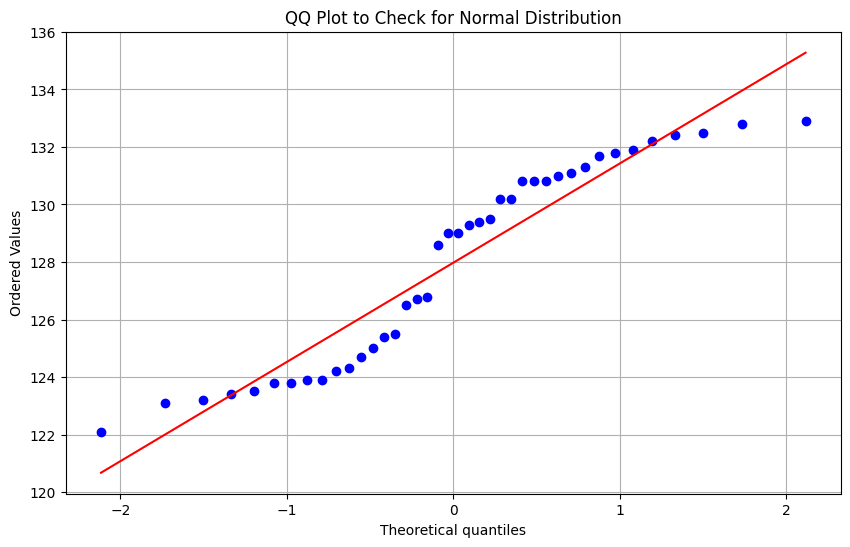

Mean: 127.97
Standard deviation: 3.45


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Given data
data = [123.5, 130.8, 124.7, 129.4, 131.8, 125.4, 130.8, 129.0, 130.8,
       128.6, 123.4, 131.3, 126.8, 132.8, 131.7, 123.9, 130.2, 123.9,
       131.9, 125.0, 132.5, 122.1, 129.3, 129.5, 125.5, 123.1, 123.8,
       130.2, 131.1, 132.4, 132.2, 126.5, 129.0, 126.7, 124.3, 124.2,
       132.9, 123.8, 131.0, 123.2]

# Create QQ plot
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(data, dist="norm", plot=ax)
plt.title("QQ Plot to Check for Normal Distribution")
plt.grid(True)
plt.show()

# Calculate basic statistics
mean = np.mean(data)
std = np.std(data)
print(f"Mean: {mean:.2f}")
print(f"Standard deviation: {std:.2f}")

Mask shape: torch.Size([15, 1024, 1024]), min: 0.0, max: 1.0, unique: tensor([0., 1.])
Mask shape: torch.Size([8, 1024, 1024]), min: 0.0, max: 1.0, unique: tensor([0., 1.])
Mask shape: torch.Size([15, 1024, 1024]), min: 0.0, max: 1.0, unique: tensor([0., 1.])


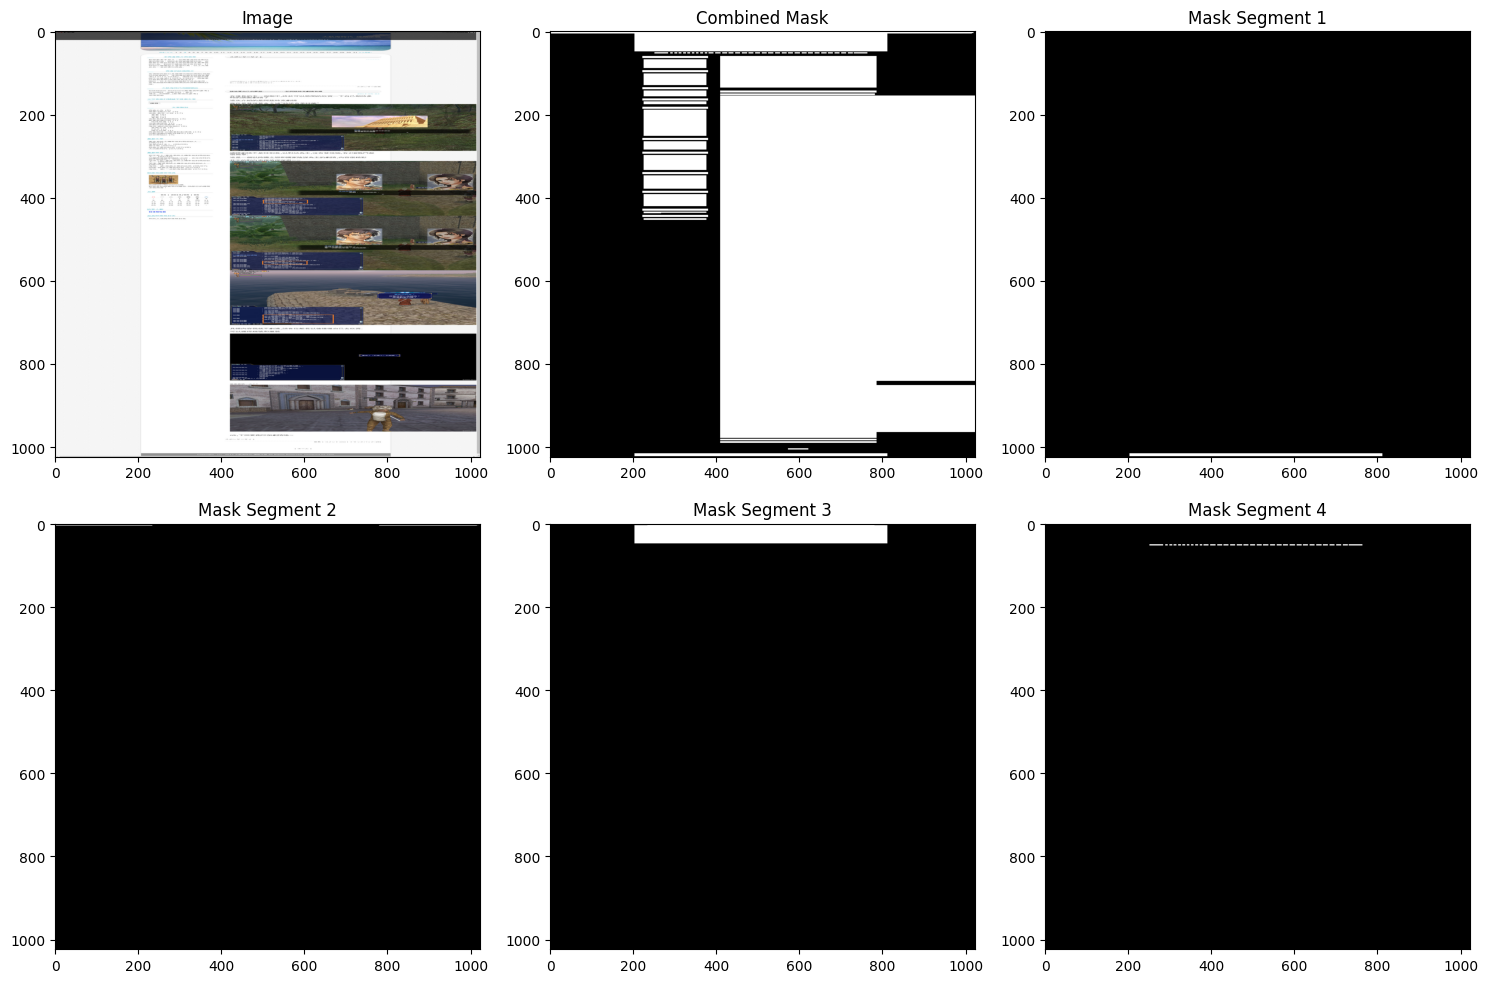

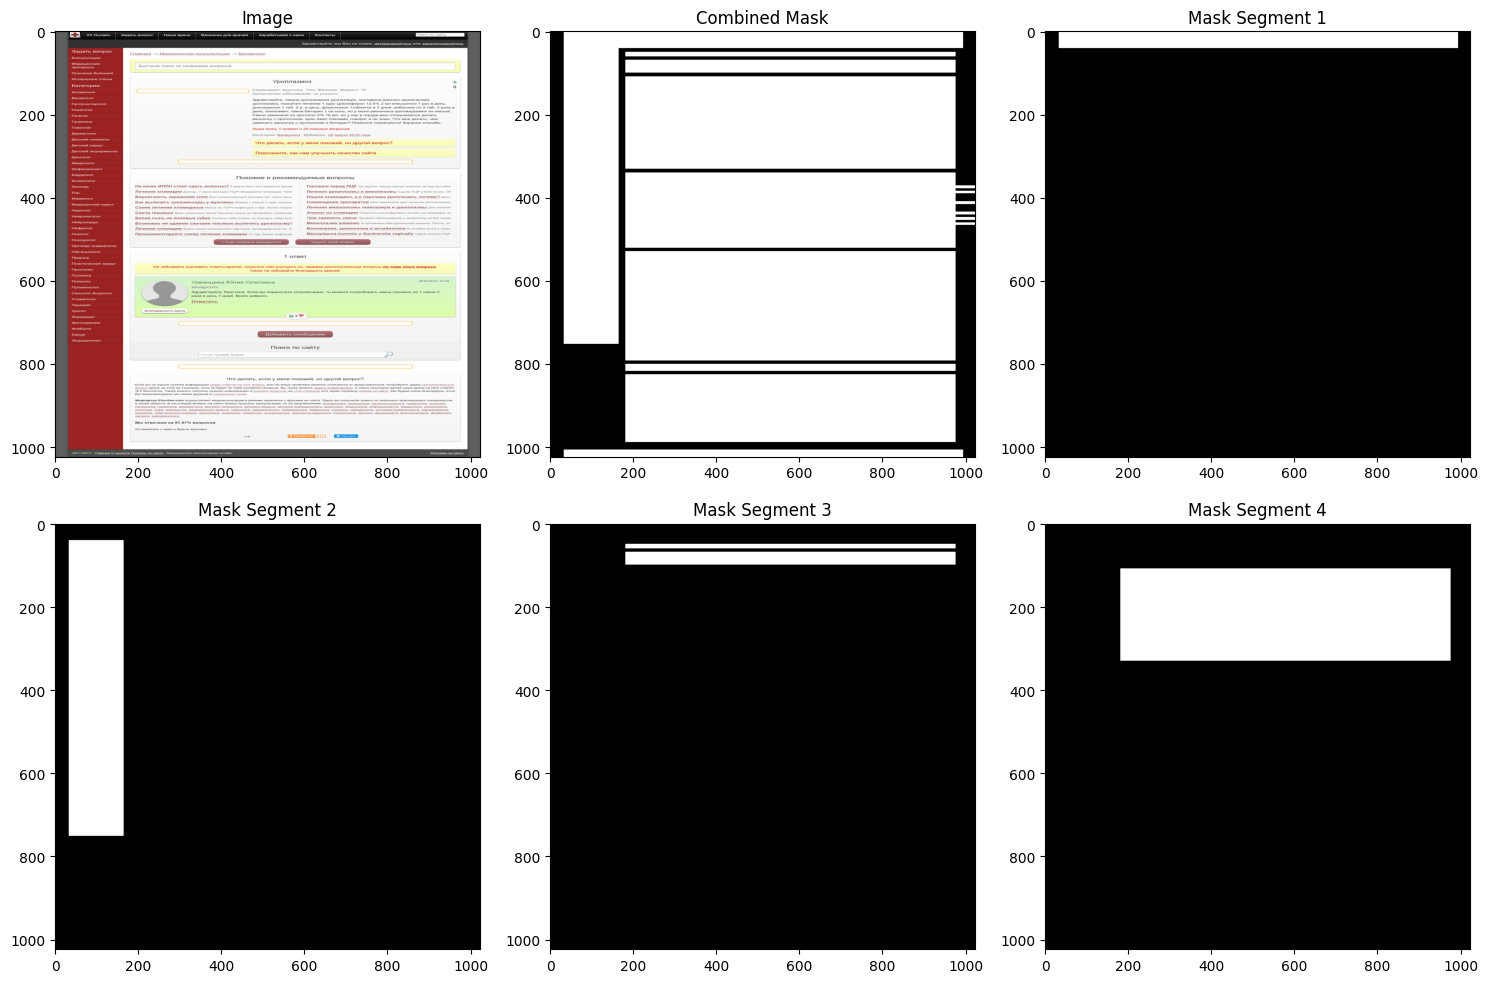

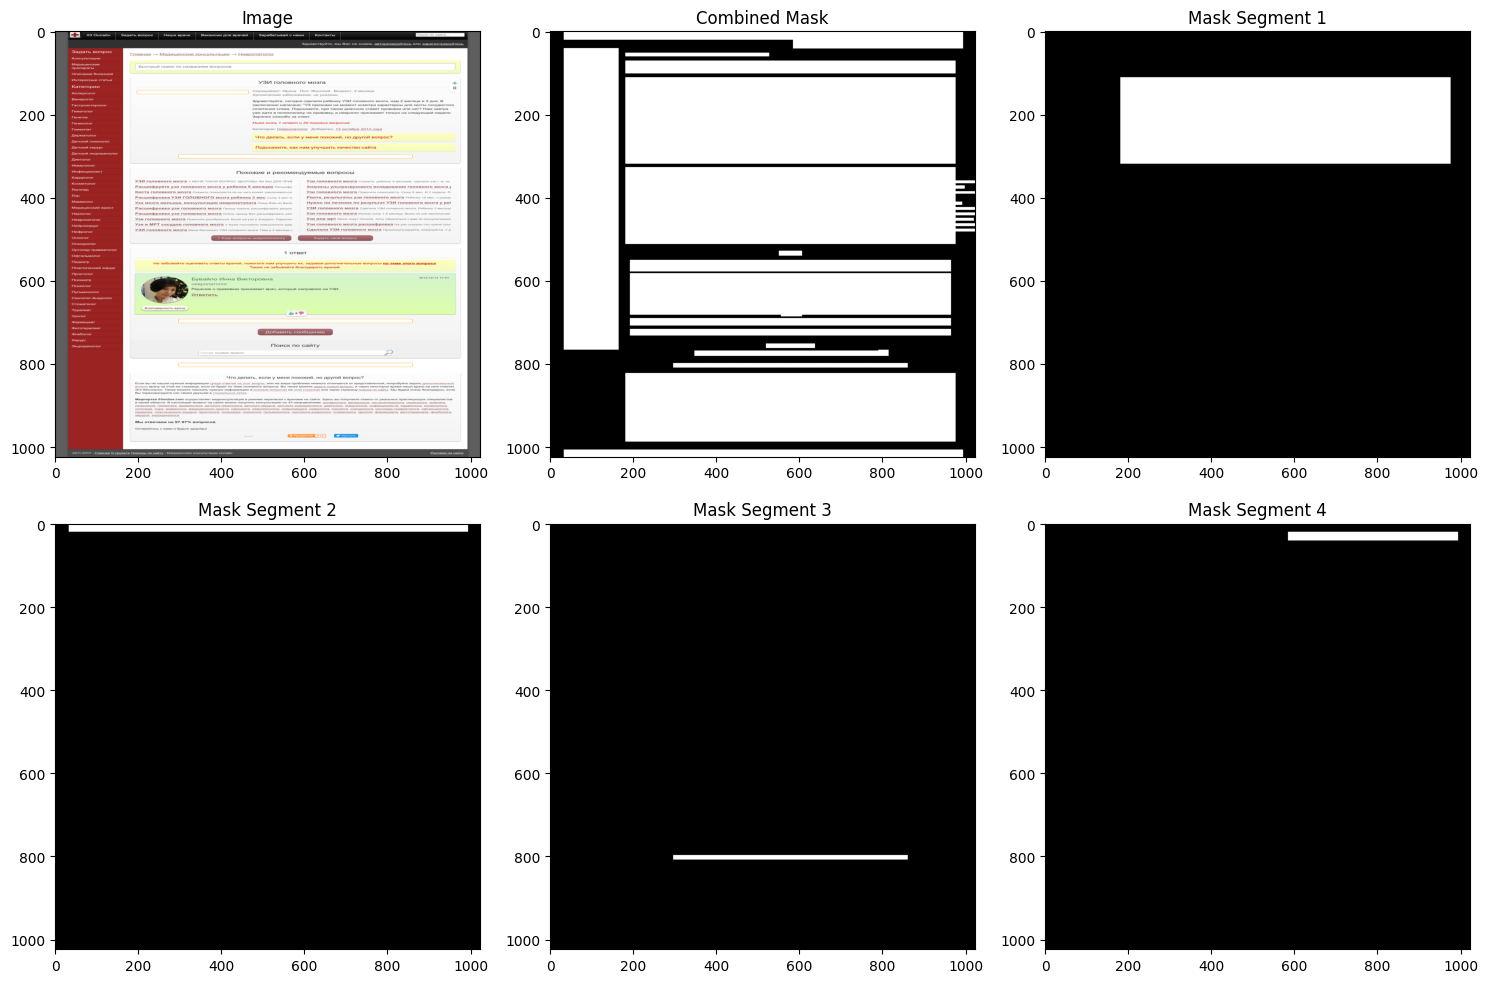

In [ ]:
# Debug dataset
dataset = WebSegDataset(root_dir="/media/bruno/New Volume/vt2-visual-webseg/data/webis-webseg-20-sam-big-segments-full/train/")
for i in range(3):
    image, box, mask = dataset[i]
    print(f"Mask shape: {mask.shape}, min: {mask.min()}, max: {mask.max()}, unique: {torch.unique(mask)}")
    
    plt.figure(figsize=(15, 10))
    
    # Show original image
    plt.subplot(2, 3, 1)
    plt.imshow(image.permute(1,2,0).numpy())
    plt.title("Image")
    
    # Show combined mask (union of all segments)
    plt.subplot(2, 3, 2)
    combined_mask = torch.any(mask > 0.5, dim=0).float().numpy()
    plt.imshow(combined_mask, cmap='gray')
    plt.title("Combined Mask")
    
    # Show first 4 individual mask segments
    for j in range(min(4, mask.shape[0])):
        plt.subplot(2, 3, j+3)
        plt.imshow(mask[j].numpy(), cmap='gray')
        plt.title(f"Mask Segment {j+1}")
        
    plt.tight_layout()
    plt.savefig(f"debug_sample_{i}.png")